# Predicción sobre los últimos $n$ días

In [1]:
import numpy as np
import math
import pandas as pd
import datetime
from pandas_datareader import DataReader
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
plt.rcParams["figure.figsize"] = (20,10)

horizonte_pred = 32

moneda = 'BTC-USD'
#Ventana de tiempo, en este caso uno, que es diario.
window = 1

# Primer gran crash de diciembre de 2017 - Bien
#start = '2017-01-01'
#end = '2017-12-10'

# Mínimo en febrero de 2018 - Bien
#start = '2018-01-01'
#end = '2018-02-05'

# Crash de noviembre de 2018 - Bien
#start = '2018-01-01'
#end = '2018-11-13'

# Mínimo en diciembre de 2018 - Bien
#start = '2018-01-01'
#end = '2018-11-18'

# Crash de julio de 2019 - Bien
#start = '2019-01-01'
#end = '2019-07-09'

# Mínimo de julio de 2019 - Bien
#start = '2019-01-01'
#end = '2019-07-30'

# Crash de marzo de 2020 - Bien
#start = '2020-01-01'
#end = '2020-03-02'

# Mínimo de marzo de 2020 - Bien
#start = '2020-01-01'
#end = '2020-03-16'

# Crash de enero de 2021 - Bien
#start = '2020-01-01'
#end = '2021-01-03'

# Mínimo de enero de 2021 - Bien pero es más complejo por la alta volatilidad
#start = '2020-01-01'
#end = '2021-01-12'

# Crash de mayo de 2021 - Bien
#start = '2020-01-01'
#end = '2021-05-01'

# Mínimo de julio de 2021 - Bien
#start = '2020-01-01'
#end = '2021-07-20'

# Crash de noviembre de 2021 - Bien
#start = '2020-01-01'
#end = '2021-11-05'

# Mínimo de enero de 2022 - Bien
#start = '2021-01-01'
#end = '2022-01-22'

# Actual
start = '2022-01-01'
end = datetime.datetime.now().strftime('%Y-%m-%d')

cripto_m = DataReader(str(moneda), "yahoo")
cripto_m2 = cripto_m   

In [2]:
cripto_m = cripto_m.loc[(cripto_m.index >= start ) & (cripto_m.index < end)]

rolling = cripto_m['Close'].rolling(window = window)    
cripto_MA = rolling.mean()
cripto_MA = cripto_MA.tail(horizonte_pred)

rolling_n = cripto_m2['Close'].rolling(window = 32)
promedMol = rolling_n.mean()
promedMol = promedMol.loc[(promedMol.index >= start) & (promedMol.index < end)]

etiqueta = {0 : 'Compra', 1 : 'Incertidumbre', 2 : 'Vende'}
color = {0 : 'green',1 : 'orange',2 : 'red'}

s = pd.Series(np.arange(len(cripto_MA)))*2
cripto_MA = pd.DataFrame(cripto_MA)
cripto_MA = cripto_MA.set_index(s)
df_aux = cripto_MA 

horizonte_n = 1024/horizonte_pred
n = int(math.log(horizonte_n,2))
print(n)

for i in range(n):
    s = pd.Series(np.arange(len(df_aux)))*2
    df_aux = df_aux.set_index(s)
    index = np.arange(len(df_aux)*2)
    df_aux = df_aux.reindex(index)
    df_aux = df_aux.interpolate(method='linear')

cripto_MA = pd.DataFrame(df_aux)
print(len(cripto_MA))


5
1024


In [3]:
from PIL import Image
def img(data):
    tam = 32
    tam2 = tam*tam
    dataset = data
    data_img = np.asarray(dataset)
    mini = min(data_img)
    maxi = max(data_img)
    x = 0 
    y = 0
    df = np.zeros((tam, tam)).astype(np.uint8)
    for k in range(len(data_img)):
        df[y][x] = np.round((data_img[k] - mini) / (maxi - mini)*255)
        x += 1
        if(x == tam):
            y += 1
            x = 0
    #print(df)
    img = Image.fromarray(df)
    return img

In [4]:
model = tf.keras.models.load_model('CNN_BTC-USD_1_Sum.h5')
model.summary()

2022-05-11 21:03:56.650763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-11 21:03:56.651167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                             

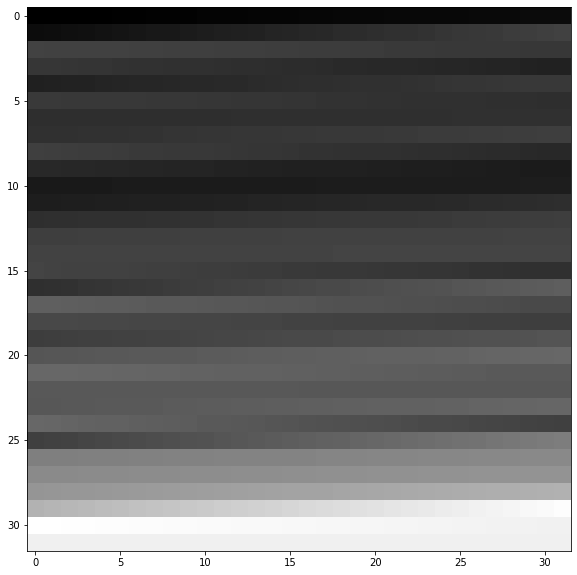

2022-05-11 21:04:00.724466: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-11 21:04:00.780638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


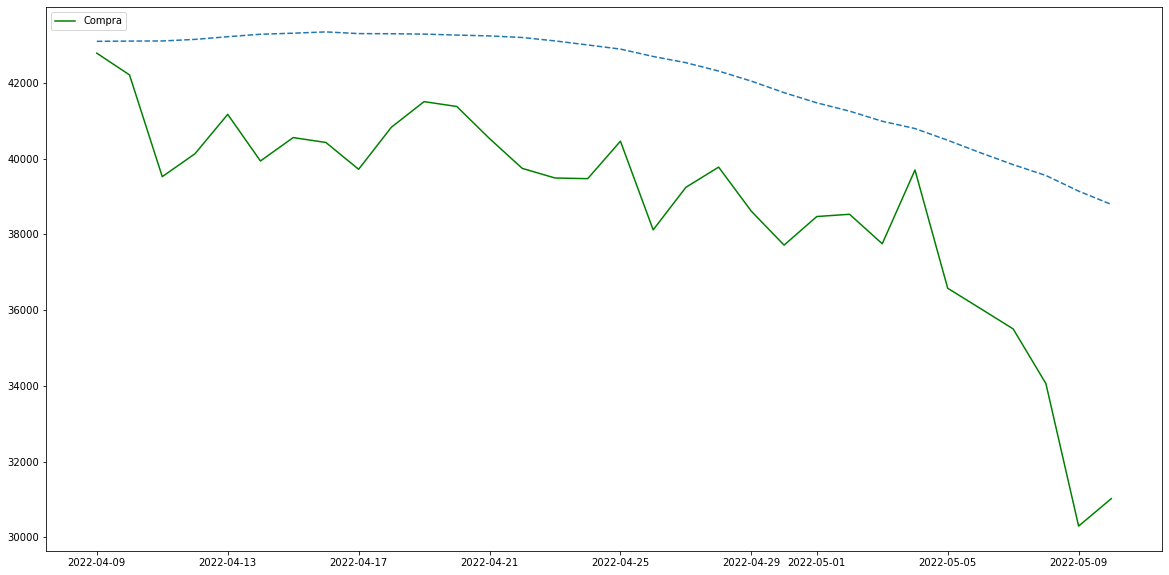

 Compra  
Color:  green
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)


In [5]:
imagen = img(cripto_MA)
plt.imshow(imagen,cmap=plt.cm.binary)
plt.show()
imagen = np.asarray(imagen).reshape(-1,32,32,1)
imagen = tf.cast(imagen, tf.float32)

etiqueta = ['Compra', 'Incertidumbre', 'Vende']
predictions = model.predict(imagen)
score = tf.nn.softmax(predictions[0])

graph, = plt.plot(cripto_m.Close.tail(horizonte_pred),color = color[np.argmax(score)], label = etiqueta[np.argmax(score)])
#plt.plot(cripto_m['Close'].tail(32),linestyle=':', alpha = 0.3)
graph_MA, = plt.plot(promedMol.tail(horizonte_pred),linestyle='--', label = "MA 30d")
plt.legend(handles=[graph],loc='upper left')
plt.show()
print("\033[1m {} \033[0m ".format(etiqueta[np.argmax(score)]))
print('Color: ',color[np.argmax(score)])
print(score)